## EDA - Segmentation des images urbaines en utilisant le Dataset CityScapes.
1. Import 
   1. Import Packages
   2. Import des données
2. Analyse de la composition des fichiers
   1. Analyse fichier leftImg8bit
   2. Analyse fichier gtFine
3. Analyse et test de réduction des categories
   1. Affichage des catégories
   2. Creation mask
   3. Test application mask
4. Préparation données
5. Conclusions

Notre mission est de concevoir un modèle de segmentation d’images, essentiel dans des domaines variés comme la reconnaissance d'objets et l'analyse médicale.

Dans un premier temps, l'Exploratory Data Analysis (EDA) nous aidera à comprendre la structure des données, identifier les tendances et les anomalies, et visualiser les premières images. Cette étape initiale nous permettra de poser les bases pour les étapes suivantes.

Ensuite, nous analyserons les différentes catégories d'images dans notre jeu de données. L'objectif sera de développer des techniques pour regrouper ces catégories et les réduire à huit, ce qui simplifiera le processus de segmentation tout en maintenant la précision.

En conclusion, la combinaison de l'EDA et de l'analyse des catégories d'images nous permettra de créer un modèle de segmentation d'images efficace et précis.



### 1. Import

#### 1.1 Import Packages

Import des libraries nécessaires pour l'EDA

1. `os` : Nous permet de travailler avec le système d'exploitation pour, par exemple, lire des fichiers à partir de répertoires.

2. `cv2` : OpenCV, une bibliothèque pour le traitement d'images et de vidéos. Nous l'utiliserons pour lire et manipuler nos images.

3. `numpy` : Une bibliothèque pour le calcul scientifique. Nous l'utiliserons pour manipuler nos images sous forme de tableaux numpy.

4. `matplotlib.pyplot` : Une bibliothèque pour la création de visualisations. Nous l'utiliserons pour afficher nos images.

5. `PIL.Image` : Une bibliothèque pour ouvrir, manipuler et sauvegarder de nombreux formats d'images différents.

6. `json` : Une bibliothèque pour travailler avec des données JSON. Nous l'utiliserons si nous avons des métadonnées stockées au format JSON.


In [25]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import json

#### 1.2 Import des données

Importation des fichiers de données :
- `leftImg8bit` : Images originales
- `gtFine` : Images étiquetées

In [2]:
# Définition des chemins des données
raw_data_path = "../data/raw"
leftImg8bit_path = os.path.join(raw_data_path, "leftImg8bit")
gtFine_path = os.path.join(raw_data_path, "gtFine")

In [3]:
# Définir les répertoires
dir_path_left = os.path.join(
    leftImg8bit_path, "train", "aachen"
)  # chemin vers le répertoire leftImg8bit
dir_path_gt = os.path.join(
    gtFine_path, "train", "aachen"
)  # chemin vers le répertoire gtFine

### 2. Analyse des fichiers

Maintenant, nous allons commencer l'analyse des deux fichiers pour mieux comprendre leur composition.

#### 2.1 Analyse fichier leftImg8bit

On passe maintentantn à se concentrer sur le fichier `leftImg8bit`.

##### 2.1.2 Affichage organisation directory

Cette fonction a été créée pour parcourir et afficher la structure des répertoires et des fichiers d'un chemin donné.

In [4]:
def print_directory_structure(path):
    total_images = 0  # Initialize a counter for total images
    # Parcourir tous les répertoires et fichiers dans le chemin donné
    for dirpath, dirnames, filenames in os.walk(path):
        # Calculer le niveau de profondeur du répertoire actuel
        level = dirpath.replace(path, "").count(os.sep)
        # Créer une indentation en fonction du niveau de profondeur
        indent = " " * 4 * (level)
        # Si le niveau de profondeur est 2 (vous pouvez changer cela selon vos besoins)
        if level == 2:
            # Si le répertoire actuel est dans 'gtFine'
            if "gtFine" in dirpath:
                # Imprimer le nom du répertoire, le nombre de fichiers et le nombre de fichiers divisé par 4
                print(
                    "{}{} - {} images ({} quand divisé par 4)".format(
                        indent,
                        os.path.basename(dirpath),
                        len(filenames),
                        len(filenames) / 4,
                    )
                )
            else:
                # Imprimer le nom du répertoire et le nombre des images
                print(
                    "{}{} - {} images".format(
                        indent, os.path.basename(dirpath), len(filenames)
                    )
                )
            total_images += len(
                filenames
            )  # Add the number of files in the current directory to the total
        else:
            # Imprimer le nom du répertoire
            print("{}{}/".format(indent, os.path.basename(dirpath)))
    print("Total number of images: ", total_images)  # Print the total number of images

In [5]:
# structure directory leftImg8bit
print("Structure du directory de leftImg8bit:")
print_directory_structure(leftImg8bit_path)

Structure du directory de leftImg8bit:
leftImg8bit/
    test/
        berlin - 544 images
        bielefeld - 181 images
        bonn - 46 images
        leverkusen - 58 images
        mainz - 298 images
        munich - 398 images
    train/
        aachen - 174 images
        bochum - 96 images
        bremen - 316 images
        cologne - 154 images
        darmstadt - 85 images
        dusseldorf - 221 images
        erfurt - 109 images
        hamburg - 248 images
        hanover - 196 images
        jena - 119 images
        krefeld - 99 images
        monchengladbach - 94 images
        strasbourg - 365 images
        stuttgart - 196 images
        tubingen - 144 images
        ulm - 95 images
        weimar - 142 images
        zurich - 122 images
    val/
        frankfurt - 267 images
        lindau - 59 images
        munster - 174 images
Total number of images:  5000


On observe donc la présence des trois subfolders : train, val et test. Chacun de ces subfolders contient des fichierde la ville d'Aachen. On peut donc en déduire que les images de la ville d'Aachen sont utilisées pour l'entraînement, la validation et le test.

On as donc, un total de $5000$ images à utiliser pour l'entrainement.

##### 2.1.1 Affichage des fichiers contenu dans leftImg8bit aachen_000000

Si on prend la première image de la ville de Aachen, on trouve ce nommage : aachen_000000_000019_leftImg8bit.PNG.
L'index de l'image est représenté par les 6 chiffres qui suivent le nom de la ville.
Nous allons l'utiliser pour extraire les images.

Tout d'abord, nous déterminons s'il y a bien une seule image originale dans le fichier `leftImg8bit/train/aachen`.

In [6]:
# Récupérer tous les fichiers qui commencent par 'aachen_000000'
files = [f for f in os.listdir(dir_path_left) if f.startswith("aachen_000000")]
# Imprimer les noms des fichiers
for file in files:
    print(file)

aachen_000000_000019_leftImg8bit.png


##### 2.1.3 Affichage image

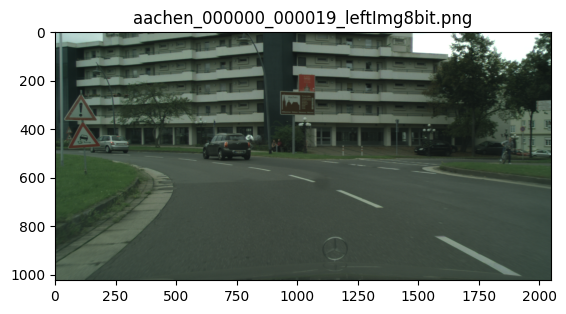

In [7]:
# Define the image path
img_path_left = os.path.join(
    leftImg8bit_path, "train", "aachen", "aachen_000000_000019_leftImg8bit.png"
)

# Open the image
img = Image.open(img_path_left)

# Display the image
plt.imshow(img)
plt.title("aachen_000000_000019_leftImg8bit.png")
plt.show()

Les images contenues dans `leftImg8bit` montrent une POV d'une voiture dans la ville.

### 2.2 Analyse fichier gtFine

##### 2.2.2 Affichage organisation directory

In [8]:
# structure de directory gtFine
print("Directory structure of gtFine:")
print_directory_structure(gtFine_path)

Directory structure of gtFine:
gtFine/
    test/
        berlin - 2176 images (544.0 quand divisé par 4)
        bielefeld - 724 images (181.0 quand divisé par 4)
        bonn - 184 images (46.0 quand divisé par 4)
        leverkusen - 232 images (58.0 quand divisé par 4)
        mainz - 1192 images (298.0 quand divisé par 4)
        munich - 1592 images (398.0 quand divisé par 4)
    train/
        aachen - 696 images (174.0 quand divisé par 4)
        bochum - 384 images (96.0 quand divisé par 4)
        bremen - 1264 images (316.0 quand divisé par 4)
        cologne - 616 images (154.0 quand divisé par 4)
        darmstadt - 340 images (85.0 quand divisé par 4)
        dusseldorf - 884 images (221.0 quand divisé par 4)
        erfurt - 436 images (109.0 quand divisé par 4)
        hamburg - 992 images (248.0 quand divisé par 4)
        hanover - 784 images (196.0 quand divisé par 4)
        jena - 476 images (119.0 quand divisé par 4)
        krefeld - 396 images (99.0 quand divisé 

Dans le fichier gtFine, on trouve la même organisation des fichiers, avec la presence de $20 000$ fichiers ($4 * 5000$) entre images et JSON

##### 2.2.1 Affichage des fichiers contenu dans gtFine aachen_000000

In [9]:
# Récupérer tous les fichiers qui commencent par 'aachen_000000'
files = [f for f in os.listdir(dir_path_gt) if f.startswith("aachen_000000")]

# Imprimer les noms des fichiers
for file in files:
    print(file)

aachen_000000_000019_gtFine_color.png
aachen_000000_000019_gtFine_instanceIds.png
aachen_000000_000019_gtFine_labelIds.png
aachen_000000_000019_gtFine_polygons.json


Ici on voi que pour un fichier dans ``gtFine/aachen/`` on peut trouver 4 fichier
- color.png

- polygons.jsons

- instanceIds.png

- labelIds.png

##### 2.2.3 Affichage image

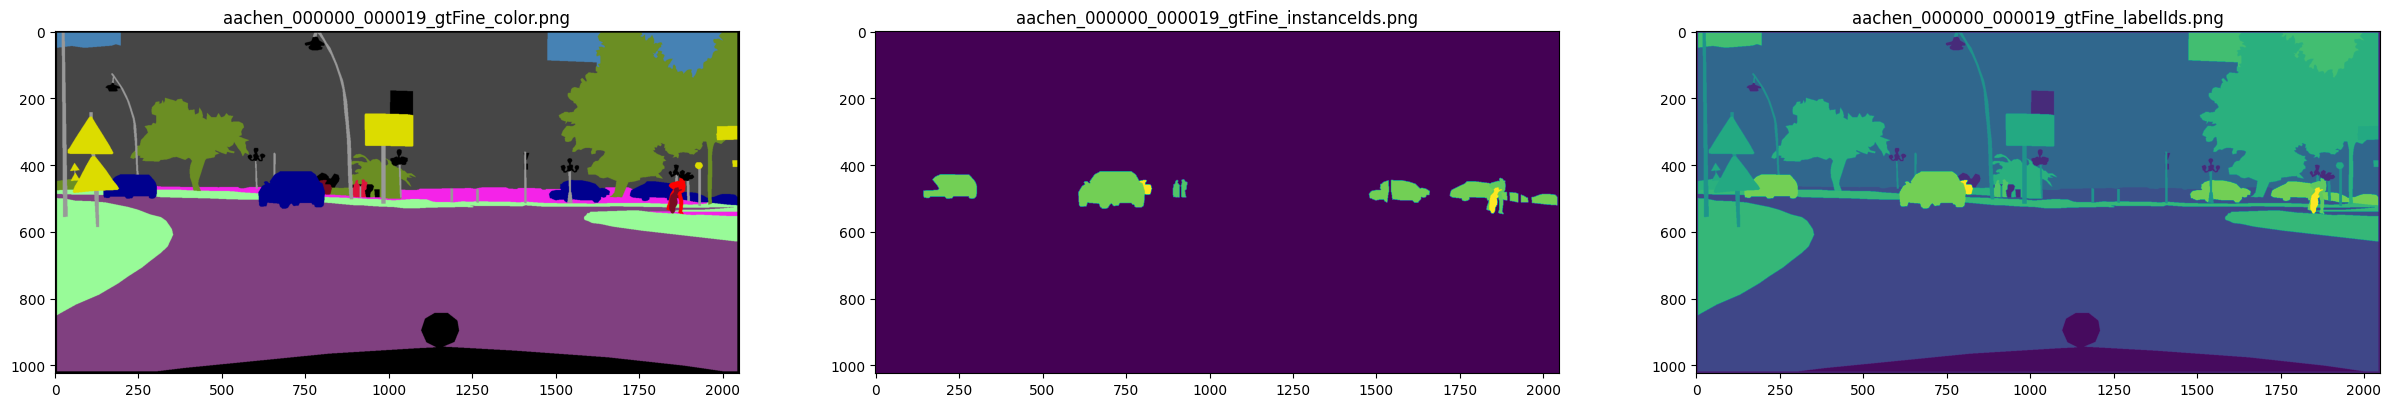

In [10]:
# Récupérer tous les fichiers qui commencent par 'aachen_000000' et se terminent par '.png'
files = [
    f
    for f in os.listdir(dir_path_gt)
    if f.startswith("aachen_000000") and f.endswith(".png")
]

# Créer une nouvelle figure pour les images
plt.figure(figsize=(10 * len(files), 10))

# Afficher les images
for i, file in enumerate(files, start=1):
    img = Image.open(os.path.join(dir_path_gt, file))

    plt.subplot(1, len(files), i)
    plt.imshow(img)
    plt.title(file)

plt.show()

Dans le fichier `gtFine`, en recherchant le meme index que avant, on trouve trois masques qui permettent de mettre en evidence les images originales.

On trouve aussi un fichier JSON, appelée `polygons.json` avec les informations liées aux ids, les polygons, et comment les identifier.

### 3. Catégories
Le jeu de données Cityscapes contient 30 classes, comme défini dans la [Définition des Classes](https://www.cityscapes-dataset.com/dataset-overview/) sur le site officiel de Cityscapes. Notre objectif est de créer un masque pour réduire ces 30 sous-classes en 8 classes principales. Pour ce faire, nous utiliserons les définitions de classes fournies dans le [dépôt GitHub officiel de Cityscapes](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py). Nous créerons ensuite des masques à appliquer à notre jeu de données.
Pour notre modelisation, on vas utiliser sourtout les fichier labelsID qui contiennent les masques avec tous les instances.

On prend la première ville disponible dans le fichier train : ``Aachen`` et la le première image avec le code comme avant `aachen_000000_000019`

In [11]:
list_dir = os.listdir(os.path.join(leftImg8bit_path, "train"))
city = "aachen"
filename = "aachen_000000_000019_gtFine_labelIds.png"

#### 3.1 Affichage de categories 

Tout d'abord, nous allons effectuer un contrôle pour observer combien d'identifiants sont présents dans l'image de référence.

On vas charger le labelid de la première image de aachen, donc on vas chercher tous le coleurs unique (ids) dans l'images et compter combien de fois chaque couleur apparaît.

In [12]:
def substring_after(s, delim):
    # Cette fonction renvoie la sous-chaîne après le délimiteur spécifié dans la chaîne donnée
    return s.partition(delim)[2]


# Load the image
img = cv2.imread(os.path.join(gtFine_path, "train", city, filename))

if img is not None and len(img.shape) == 3:
    na = np.array(img)
    colours, counts = np.unique(na.reshape(-1, 3), axis=0, return_counts=1)

    print(f"{substring_after(filename, 'gtFine_')} :")

    for j in range(len(colours)):
        print(f"    {colours[j]}: {counts[j]}")

    # Print the number of unique IDs
    print(f"Number of unique IDs: {len(colours)}")
else:
    print(f"Image {filename} could not be loaded or is not a color image.")

labelIds.png :
    [0 0 0]: 9
    [1 1 1]: 81534
    [3 3 3]: 31634
    [4 4 4]: 14664
    [7 7 7]: 831082
    [8 8 8]: 29195
    [11 11 11]: 611938
    [17 17 17]: 22846
    [20 20 20]: 34863
    [21 21 21]: 221654
    [22 22 22]: 130185
    [23 23 23]: 38722
    [24 24 24]: 1588
    [25 25 25]: 2270
    [26 26 26]: 42659
    [33 33 33]: 2309
Number of unique IDs: 16


On voit clairement qu'il y a 16 identifiants différents dans l'image aachen_000000_000019_gtFine_labelIds.png.

Cela sera notre référence pour vérifier ultérieurement si notre masque a correctement affecté l'image.

#### 3.2 Creation Masks pour reduire les categories https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

Maintenant on vas créer les masques à appliquer sur notre images pour réduire les categories à 8.

In [13]:
cats = {
    "void": [0, 1, 2, 3, 4, 5, 6],
    "flat": [7, 8, 9, 10],
    "construction": [11, 12, 13, 14, 15, 16],
    "object": [17, 18, 19, 20],
    "nature": [21, 22],
    "sky": [23],
    "human": [24, 25],
    "vehicle": [26, 27, 28, 29, 30, 31, 32, 33, -1],
}

cats_color = {
    "void": (0, 0, 0),  # Black
    "flat": (128, 0, 128),  # Purple
    "construction": (128, 128, 128),  # Grey
    "object": (255, 255, 0),  # Yellow
    "nature": (0, 128, 0),  # Green
    "sky": (173, 216, 230),  # Light Blue
    "human": (255, 0, 0),  # Red
    "vehicle": (0, 0, 255),  # Blue
}

cats_id = {
    "void": (0),
    "flat": (1),
    "construction": (2),
    "object": (3),
    "nature": (4),
    "sky": (5),
    "human": (6),
    "vehicle": (7),
}

#### 3.3 test application mask sur les images

Maintenant on va appliquer les masques des ids et des coleurs sur les images, et puis on vas faire une affichage pour observer les nouveaux images.

Ce function crée deux masques à partir d'une image : `mask_labelids` qui identifie les différentes catégories dans l'image, et `mask_colorids` qui applique une couleur spécifique à chaque catégorie. 

Les catégories et leurs couleurs correspondantes sont définies dans les dictionnaires `cats` et `cats_color`.

In [14]:
img = cv2.imread(os.path.join(gtFine_path, "train", city, filename))
img = np.squeeze(img[:, :, 0])
mask_labelids = np.zeros((img.shape[0], img.shape[1], len(cats_id)))
mask_colorids = np.zeros((img.shape[0], img.shape[1], 3))  # New mask for colors

for i in range(-1, 34):
    for cat in cats:
        if i in cats[cat]:
            mask_labelids[:, :, cats_id[cat]] = np.logical_or(
                mask_labelids[:, :, cats_id[cat]], (img == i)
            )
            mask_colorids[(img == i)] = cats_color[cat]  # Apply color mask
            break

mask_labelids = np.array(np.argmax(mask_labelids, axis=2), dtype="uint8")
mask_colorids = mask_colorids.astype("uint8")  # Convert to uint8 for image display

On vas appliquer les masque et montrer contrôler si on as biens le 8 classes.

In [15]:
colours, counts = np.unique(mask_labelids, return_counts=1)

print(f"{substring_after(filename, 'gtFine_')} :")

for j in range(len(colours)):
    print(f"    {colours[j]}: {counts[j]}")

labelIds.png :
    0: 127841
    1: 860277
    2: 611938
    3: 57709
    4: 351839
    5: 38722
    6: 3858
    7: 44968


On vois que la mask à bien réduite les categories, et maintenant on faire un affichage des images, avec les labelsIds et aves la masque avec le nouveaux couleurs que on vas utiliser sur l'affichage de previsions des nos modèles.

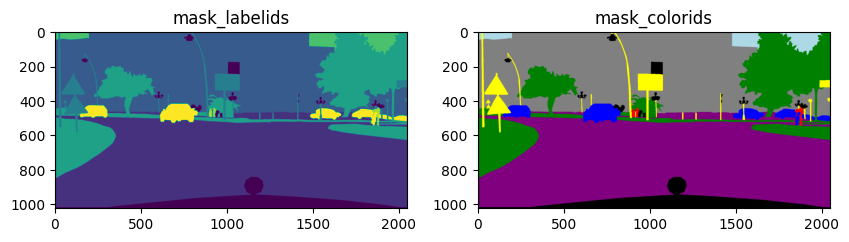

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 2 subplots

# Display mask_labelids on the first subplot
axs[0].imshow(mask_labelids)
axs[0].set_title("mask_labelids")

# Display mask_colorids on the second subplot
axs[1].imshow(mask_colorids)
axs[1].set_title("mask_colorids")

plt.show()

### 4. Préparation des données
On vas effectuer l'entrainement du modèle sur plusieurs modelisation, alors on vas effectuer un resize des images pour rendre l'entrainement plus rapide, mais cela vas quand même être nuisible pour la performance du modèle.
Cela vas aussi nous permettre de faire diminuire le poids des images dans notre directory en passant de 12gb à 4gb seulement.

In [17]:
# définition du fichier avec les données resized
processed_data_path = "../data/processed/res_data"

Ce code commence par créer un répertoire nommé processed_data_path s'il n'existe pas déjà.

Ensuite, le code parcourt tous les sous-répertoires ('test', 'train', 'val') dans un répertoire nommé leftImg8bit_path. Pour chaque sous-répertoire, il parcourt toutes les villes dans ce sous-répertoire, en les triant par ordre alphabétique. Pour chaque ville, il parcourt tous les fichiers dans le répertoire de cette ville, également triés par ordre alphabétique.

Pour chaque fichier, le code lit l'image à partir du fichier, la redimensionne à une taille de (1024, 512), puis sauvegarde l'image redimensionnée dans le répertoire processed_data_path, dans un sous-répertoire 'leftImg8bit', qui contient des sous-répertoires pour chaque sous-répertoire et chaque ville du répertoire leftImg8bit_path.

Le code fait ensuite la même chose pour un autre répertoire nommé gtFine_path, mais sauvegarde les images redimensionnées dans un sous-répertoire 'gtFine' du répertoire processed_data_path.

In [33]:
import sys
sys.path.append("../script/")
import functions as fc

In [34]:
# Listes des chemins des images
raw_data_path = "../data/raw"
x_train_path, x_test_path, x_val_path = fc.getPathFiles(leftImg8bit_path)
# Listes des chemins des masques
y_train_path, y_test_path, y_val_path = fc.getPathFiles(gtFine_path, "labelIds.png")

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: '../data/raw\\leftImg8bittrain/'

In [23]:
data_res_path = "../data/processed/res_data"

# Check if the directory already exists
if not os.path.exists(data_res_path):
    os.mkdir(data_res_path)

    # Iterate over the directories in 'data/raw'
    for dir_1 in os.listdir("../data/raw"):
        if (
            dir_1 != "img"
            and dir_1 != ".DS_Store"
            and os.path.isdir(os.path.join("../data/raw", dir_1))
        ):
            os.mkdir(os.path.join(data_res_path, dir_1))
            for dir_2 in os.listdir(os.path.join("../data/raw", dir_1)):
                if dir_2 != ".DS_Store":
                    os.mkdir(os.path.join(data_res_path, dir_1, dir_2))
                    for dir_3 in os.listdir(os.path.join("../data/raw", dir_1, dir_2)):
                        if dir_3 != ".DS_Store":
                            os.mkdir(os.path.join(data_res_path, dir_1, dir_2, dir_3))

    all_images_path = (
        x_train_path
        + x_test_path
        + x_val_path
        + y_train_path
        + y_test_path
        + y_val_path
    )

    print(f"Number of images to process: {len(all_images_path)}")

    # Resize and save the images in the new directory
    for path in all_images_path:
        if ".DS_Store" not in path:
            img = cv2.imread(path)
            if img is None:
                print(f"Failed to read image at {path}")
                continue
            img = cv2.resize(img, (1024, 512))
            new_path = path.replace(raw_data_path, "../data/processed/res_data")
            cv2.imwrite(new_path, img)
            print(f"Saved resized image to {new_path}")

else:
    print(f"Dossier {data_res_path} existe déjà")

### 5. Conclusion

En conclusion, notre analyse exploratoire des données a fourni des informations précieuses sur la structure et la composition de notre ensemble de données. Nous avons examiné en profondeur l'organisation des images et quantifié les données disponibles, qui se composent d'un nombre substantiel d'images couvrant plusieurs villes.

Une étape significative de notre préparation des données a été la réduction des catégories de classes de 30 à 8. Cette simplification devrait rationaliser notre processus de modélisation et potentiellement améliorer les performances de nos modèles en se concentrant sur des catégories plus larges.

Pour la phase de modélisation, nous avons décidé d'utiliser toutes les villes disponibles dans notre ensemble de données. Cette approche garantit un ensemble de données diversifié et complet, ce qui est crucial pour former des modèles robustes et généralisables.

Cependant, il est important de noter que nous avons redimensionné les images dans le cadre de notre prétraitement des données. Bien que cette étape réduise les exigences computationnelles et accélère le processus d'entraînement, elle peut également affecter les performances des modèles en raison du niveau de détail réduit dans les images. C'est un compromis que nous avons considéré et accepté dans notre approche.

À l'avenir, nous surveillerons les effets de ces décisions pendant la phase d'entraînement du modèle. Nous sommes prêts à revoir et à réviser nos stratégies en fonction des performances et des exigences de nos modèles.